# **NDMI With Dask**

This tutorial notebook demonstrates how to find, visualize, and analyze the Normalized Difference Moisture Index with Landsat 8 imagery efficiently using Dask. Landsat 8 has a spatial resolution of 30 meters and temporal resolution of 16 days, which makes it ideal for medium scale imagery for water mapping. We will be focusing on an area around Saint-Roch-de-l'Achigan to the North-West of Montreal.


**What is NDMI?**

The Normalized Difference Moisture Index (NDMI) detects vegetation moisture using short-wave infrared radiation (SWIR) bands and near-infrared radiation (NIR) bands. It can be used as an idicator of water stress in crops.

When the index makes use of visible green light and near-infrared radiation in it's formula it can be used to enhance the open water features and remove presence of soil and vegetative features. This allow's NDMI to estimate the turbidity of water bodies.  


**How is NDMI calculated?**

There are two way of calculating NDMI (also called NDWI).

1. To monitor changes in the water content of vegetation, using the near-infrared radiation (NIR) and shortwave infrared radiation (SWIR) bands. 
    * **`NDMI = (NIR-SWIR)/(NIR+SWIR)`**

2. To monitor changes in the water content of water bodies, use visible green light and near-infrared radiation (NIR) bands.
    * `NDMI = (Green-NIR)/(Green+NIR)` 

**What do NDMI values represent?**

Similar to the results of NDVI, the NDMI formula generates a value between -1.0 to 1.0. Negative values nearing -1 would indicate water-related stress, while positive values nearing +1 could suggest waterlogging.


## 1. Initialize your Dask Gateway Clusters
Since we want to use eight years of data for our analysis, running the computation using the cores of the machine we are running this notebook on is not ideal. Let's connect to Dask Gateway so we can create a cluster that can run our work.

For now, we will set our cluster to scale the workers to 5, because of the amount of data we will be working with. 

In [ ]:
# We will be using Landsat8 Collection2 Surface Reflectance imagery from Microsoft Planetary Computer's STAC server:
!pip install planetary_computer
!pip install geogif

In [ ]:
# First initialize the modules 
import os
import glob
import json
import geogif
import stackstac
import planetary_computer

import dask
import rasterio

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xrspatial.multispectral as ms

from geogif import dgif, gif
from pystac_client import Client
from dask_gateway import Gateway
from shapely.geometry import Polygon
from IPython.display import clear_output
from dask.distributed import wait, progress
from xrspatial.focal import mean, focal_stats, hotspots

In [23]:
gateway = Gateway()

# Cluster configuration 
options = gateway.cluster_options()
cluster = gateway.new_cluster(options)

In [24]:
# Scale the cluster
workers = 5
cluster.scale(workers) 

In [25]:
# Configure client
client = cluster.get_client() 

In [26]:
client.wait_for_workers(workers-1)
cluster

In [ ]:
gateway.list_clusters()

## 2. Get the Landsat 8 Data
The Microsoft Planetary Computer provides Landsat 7/8/9 satellite images for public use. We will specifically use Collection 2 Level 2. 

In the following section we will learn how to query the Planetary Computer STAC API to obtain the data we want and use Stacstack to compile the outputs into an Xarray dataframe.
Let's take a look at the steps we'll be following.

1. Start by creating a polygon which will serve as our Area of Interest (AOI).
2. Next we will start the planetary computer STAC API, and configure the parameters we want to query against. 
3. The next step is to loop by year and query the STAC API based on our query search parameters.
4. Finally, we use Stackstac to create an Xarray DataArray containing the data we want! 

In [28]:
# Create a polygon for defining our Area of Interest (AOI) in this case we are using a rough buffer around Saint-Roch-de-l'Achigan, Quebec, created using: https://www.keene.edu/campus/maps/tool/
polygon={
  "coordinates": [
    [
      [
        -73.6574936,
        45.974299
      ],
      [
        -73.8305283,
        45.8613249
      ],
      [
        -73.8054657,
        45.7782991
      ],
      [
        -73.5514069,
        45.8608467
      ],
      [
        -73.6574936,
        45.974299
      ]
    ]
  ],
  "type": "Polygon"
}

In [29]:
lon_list = []
lat_list = []

for lon,lat in polygon['coordinates'][0]:
    lon_list.append(lon)
    lat_list.append(lat)
polygon_geom = Polygon(zip(lon_list, lat_list))
crs = 'EPSG:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
polygon

geometry
0  POLYGON ((-73.65749 45.97430, -73.83053 45.861...

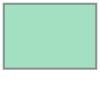

In [30]:
FOOTPRINT = polygon.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [31]:
FOOTPRINT.bounds

(-73.8305283, 45.7782991, -73.5514069, 45.974299)

In [ ]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

In [33]:
# CONFIG 
# -------------
TGT_BANDS =  ['nir08', 'swir16']
YEARS = ['2016','2017','2018','2019','2020','2021','2022']
BEGIN_MONTH = '04'
END_MONTH = '10'
MAX_CLOUD = 10
WRS_ROW = "028" # WRS row that covers Saint-Roch-de-l'Achigan
EPSG = 32618 # WGS84 / UTM zone 18N
READ_IN_CHUNK = 4096
RESOLUTION = 30
TEMPORAL_CHUNK = {'time': -1, 'band': 1, 'x': 128, 'y': 128}
# -------------

In [ ]:
item_dict = []
for year in YEARS:
    date_range = f'{year}-{BEGIN_MONTH}-01/{year}-{END_MONTH}-30'
    
    # Query the Planetary Computer STAC server with pystac_client
    print(f'[Querying] {year}')
    items = api.search(
        collections = ['landsat-c2-l2'],
        intersects = FOOTPRINT,
        query={"eo:cloud_cover": {"lt": MAX_CLOUD},"platform":{"eq":"landsat-8"},"proj:epsg":{"eq":EPSG},"landsat:wrs_row":{"eq":WRS_ROW}},
        datetime = date_range,
    ).get_all_items()
    
    
    print(f'\tFound {len(items)} items')
    # planetarycomputer requires signed URLs to access Asset HREFs. 
    print('\t[Signing data links]')
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    item_dict+=signed_items
        
# Convert STAC query into a xarray.DataArray
# with Stackstac
print('\t[Converting STAC query to DataArray]')
data = (
    stackstac.stack(
        item_dict,
        assets=TGT_BANDS, 
        chunksize=READ_IN_CHUNK, # Set chunksize
        resolution=RESOLUTION, # Set all bands res to this
        bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
        epsg = EPSG
    ).where(lambda x: x > 0.0, other=np.nan).assign_coords(
        time=lambda x: x.time.dt.round(
            "D"
        )) 
)
data

## 3. Calculating the NDMI

Now that we have all the data in the right place, let's compute the NDMI on the data! To efficiently get the NDMI for all the data, we will need a helper function to normalize our data.

### 3.1 Normalization Function

Normalization is a procedure of adjusting values measured on a different scale to a common scale. We will normalize the data so the computation of NDMI is done on the same scale of values. 

In [35]:
def normalize(array):
    norm = (array - array.min()) / (array.max() - array.min())
    return norm

In [ ]:
normalized = normalize(data)

normalized

### 3.2 Calculate the NDMI of each granule

Our area of interest is a buffer around Saint-Roch-de-l'Achigan, Quebec (to the North-West of Montreal). As this region is predominantly agricultural, we will use the **first method** with Landsat 8's Band 5 for NIR channel and Band 6 for the SWIR channel.
Once the data have been normalized we will calculate the NDMI using the XArraySpatial's Multispectral package which enables us to calculate indices in one line!

In [37]:
ndmi_aggs = [ms.ndmi(x.sel(band="nir08"), x.sel(band="swir16")) for x in data]

ndmi = xr.concat(ndmi_aggs, dim="time")

## 4. Visualizing the Results

### 4.1 Plotting

To see how the NDMI changes over time, we can visualize it using Matplotlib's **plot** function.

The cell below groups the images according to the time each image was taken and plots the entire dataset.

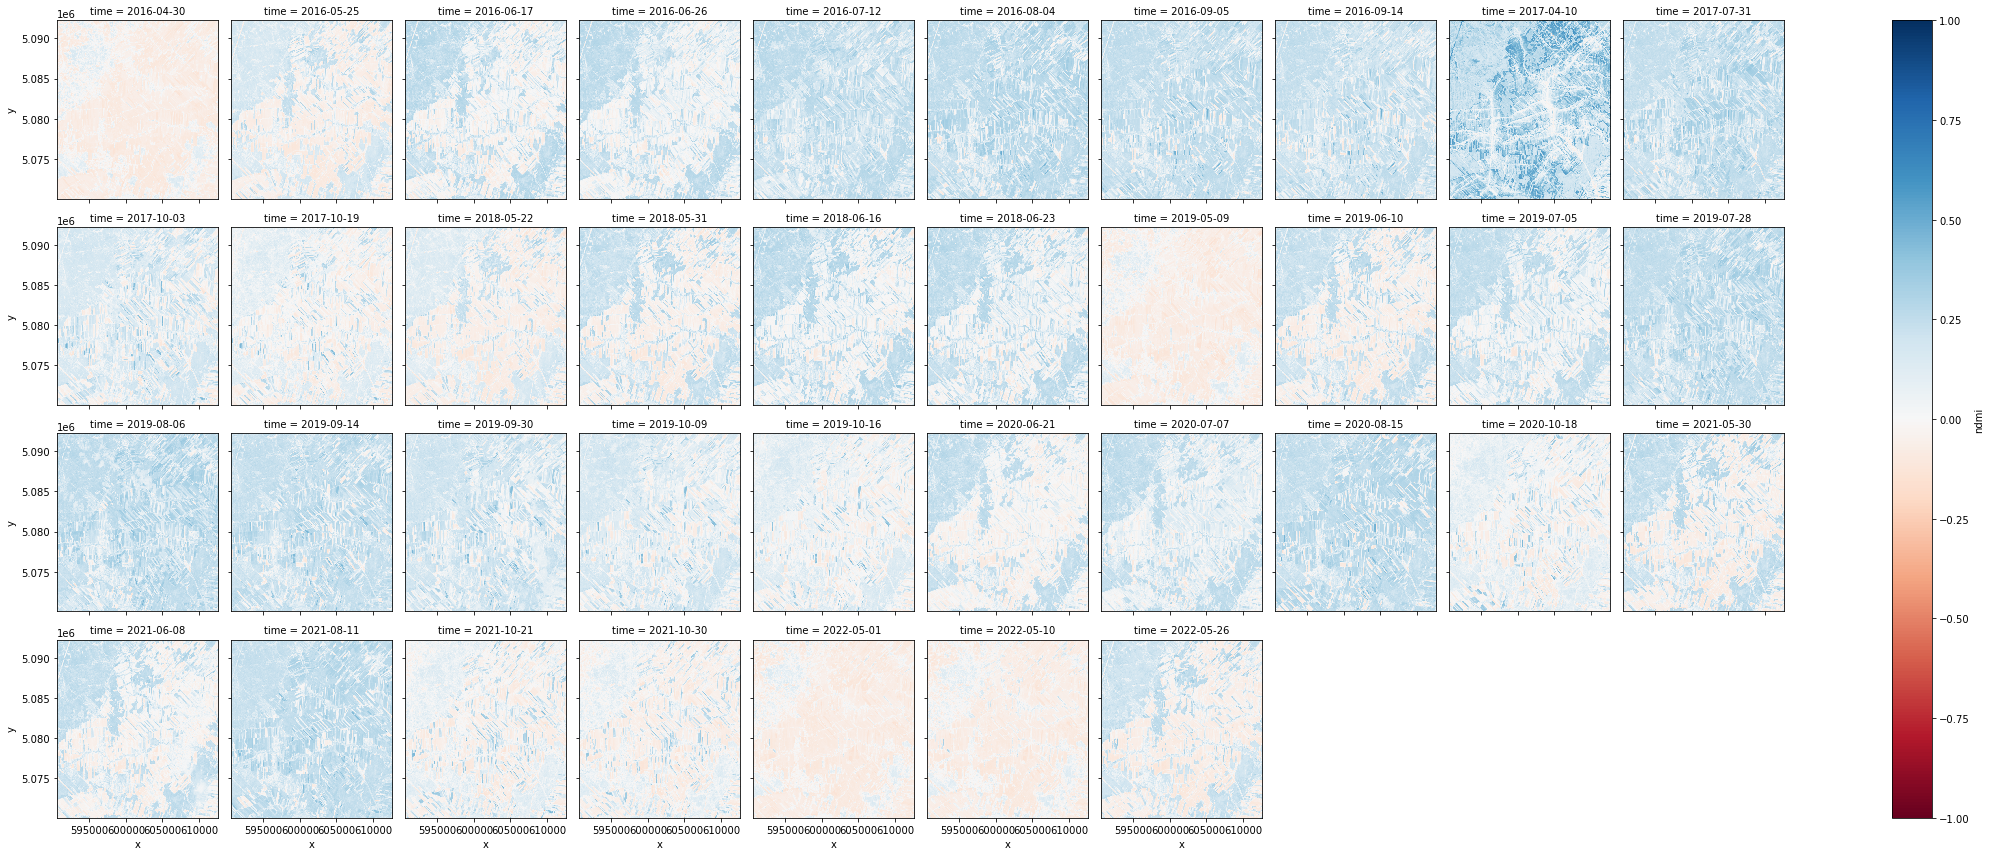

In [46]:
ndmi.plot.imshow(x='x',y='y',col="time", col_wrap=10, vmin=-1, vmax=1, cmap="RdBu")

### 4.2 Creating a GIF

To stack our images and animate them as a GIF we can use geogif's **gif** function.

It allows us to specify our frames per second and the color map we wish to use.

The GIF below shows change in the NDMI in the region around Saint-Roch-de-l'Achigan to the North-West of Montreal. This change is helpful to visualize change in the moisture content of the crops in the area.   

The pattern of change occurs seasonally, as can be seen in the gif below when the moisture content is lower during early spring. As the growing season starts the increase in moisture content is noticeable. 

CPU times: user 1.54 s, sys: 637 ms, total: 2.18 s
Wall time: 18.4 s


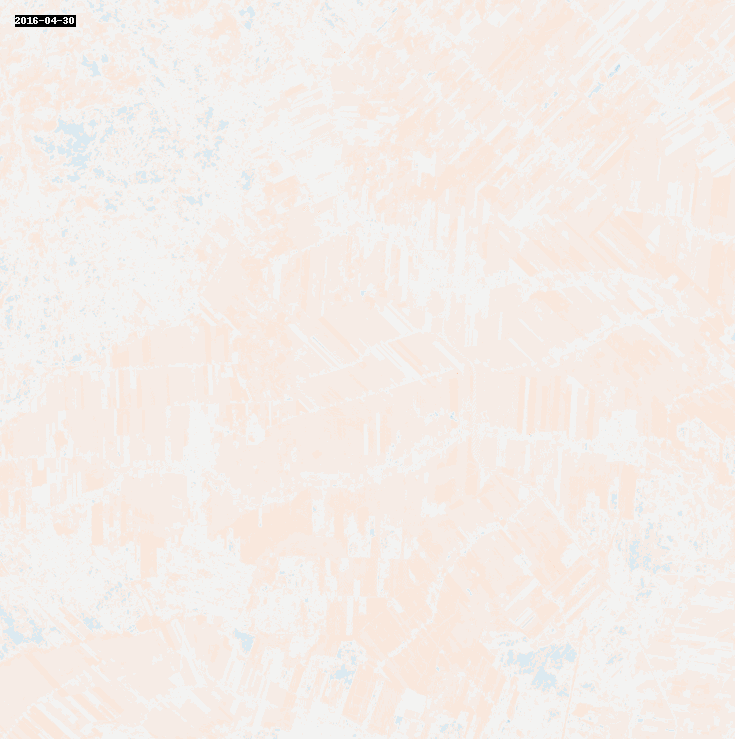

In [47]:
%%time
# Creates gif 
gif(ndmi.compute(), fps=3, vmin=-1, vmax=1, cmap="RdBu")

### 4.3 Analysis

In [26]:
#UTM zone 18N coordinates near Montreal
xcen = 601626 
ycen = 5081200 
buf = 500  # look at point +/- 500m

The graph below shows NDMI from April 2016 until September 2016. As you can see the NDMI values start in the low negatives at the start of the growing season, however, as the healthy crops grow the NDMI follows.

Text(0.5, 1.0, 'Change of NDMI - Summer 2016')

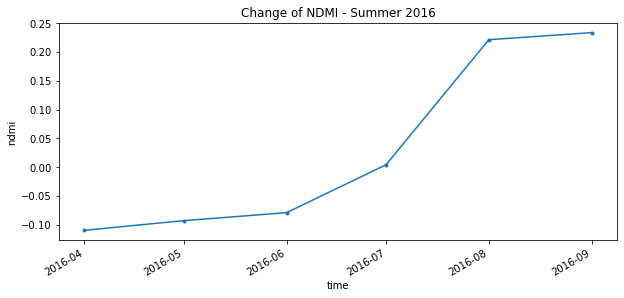

In [27]:
annual = ndmi.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen+buf,ycen-buf), time=slice('2016-01-01', '2016-12-30'))
annual_timeseries = annual.resample(time='1MS').mean().persist()

annual_timeseries.isel(x=1,y=1).plot.line(figsize=(10,4), marker='.')
plt.title("Change of NDMI - Summer 2016")

In the following graph we will average the values on a yearly basis and see the differences between years. **NOTE: The graph below is an estimated fit.**

Text(0.5, 1.0, 'NDMI Yearly averages over 6 years')

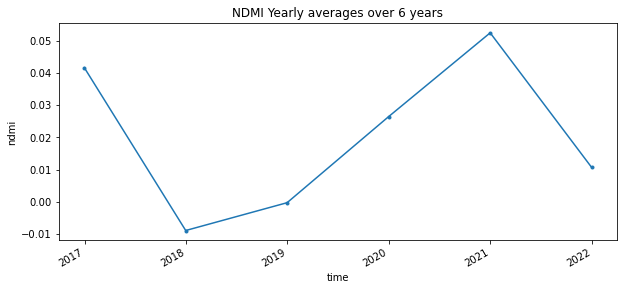

In [28]:
full_variation = ndmi.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen+buf,ycen-buf), time=slice('2016-01-01','2021-10-21'))
full_timeseries = full_variation.resample(time='1Y').mean().persist()

full_timeseries.isel(x=1,y=1).plot(figsize=(10,4), marker='.')
plt.title("NDMI Yearly averages over 6 years")

***Make sure to always explicitly shut down computing resources when you're not using them!***

In [29]:
cluster.shutdown()
client.close()